### Python scripts used for the paper entitled:
 #### Single character insertion-deletion model preserves long indels in ancestral sequence reconstruction

In [1]:
## Python 3
# long indel situation: dynamic of gap pattern for each simulated data
# Created by: Gholamhossein Jowkar <jowk@zhaw.ch>
# ACGT ZHAW
# Created date: October 2023
# Modified by: jowk
# Modified date: Nov 2023

In [31]:
import os, sys, time, statistics, json, re, fnmatch
from statistics import mean

from Bio import AlignIO, SeqIO

# from ete3 import Tree

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import spearmanr, kendalltau, pearsonr

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc

path = "./simulation_data/" #set path to the simulated data directory
os.chdir(path)

# Figures style
sns.set_style('white')
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_style('white')
sns.set_context("paper", font_scale = 1)
color_1 = sns.color_palette()[0]
color_2 = sns.color_palette()[1]


## Dynamic of sequence length

Reading the gap lenght file

In [27]:
df_dynamic = pd.read_csv('./02_dynamic_joint_age_seq_len_per_OMA_per_species.csv')
display(df_dynamic)

,Unnamed: 0,OMA_group,seq_Mus,seq_Rattus,seq_Pan,seq_Homo,seq_Gorilla,seq_Macaca,seq_V2,seq_V5,...,tree_Rattus,tree_Pan,tree_Homo,tree_Gorilla,tree_Macaca,tree_V2,tree_V5,tree_V7,tree_V9,tree_root
0,0,1000131,941,925,988,987,987,937,938,987,...,0.25761,0.25528,0.25532,0.24431,0.25761,0.17706,0.24431,0.24421,0.18448,0.0
1,1,1000249,1008,964,991,991,991,990,984,991,...,0.20723,0.18997,0.19513,0.20723,0.20511,0.15057,0.18747,0.18189,0.15558,0.0
2,2,1000358,1097,992,1006,1006,1006,1009,999,1006,...,0.13363,0.13047,0.13054,0.13362,0.13157,0.09921,0.12859,0.12849,0.11834,0.0
3,3,1000360,1000,982,998,1000,997,1000,986,998,...,0.13900,0.10883,0.11650,0.17518,0.12469,0.11426,0.10873,0.10863,0.08588,0.0
4,4,1000362,1012,1025,988,988,988,990,1025,988,...,0.02270,0.02592,0.02592,0.02582,0.02419,0.01871,0.02582,0.02572,0.02223,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,985,999139,1004,1013,1011,1011,1011,1011,1003,1011,...,0.02795,0.02822,0.02822,0.02812,0.03235,0.02070,0.02812,0.02802,0.02714,0.0
986,986,999464,1038,1048,1167,1130,1121,1016,1037,1119,...,0.08109,0.08109,0.04091,0.04205,0.05917,0.06293,0.03969,0.03844,0.02452,0.0
987,987,999465,1004,985,946,1023,1025,1005,1006,1022,...,0.14666,0.14666,0.11583,0.12039,0.12191,0.10494,0.11383,0.11165,0.08785,0.0
988,988,999520,1010,1010,1002,1003,1001,1003,1010,1002,...,0.12236,0.11920,0.12236,0.11302,0.11477,0.09835,0.11604,0.11292,0.09579,0.0


### Spearman Correlation Coefficients

In [29]:
# Correlation Coefficients
dict_spearman_coef = {}

for i in range(len(df_dynamic)):
    y = df_dynamic.iloc[i, 2:13] #y values are the sequence lengths
    x = df_dynamic.iloc[i, 13:] #x values are the corresponding distances from the root
    
    dict_spearman_coef[df_dynamic.iloc[i,1]] = spearmanr(x, y)
    

df_spearman_coef = pd.DataFrame.from_dict(dict_spearman_coef, orient='index')
df_spearman_coef.columns = ['coef', 'p-val']
df_spearman_coef.to_csv("./02_df_spearman_age_coef_w_pval.csv")


print("Done")

C:\Users\jowkar\.conda\envs\env01\lib\site-packages\scipy\stats\_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Done


### Report: Percentage of significant samples from Spearman correlation coefficient

In [4]:
#percentage of significant
print("Total number of gappy samples:",len(df_spearman_coef))
print("********************************************************")

df_significant_spearman = df_spearman_coef[df_spearman_coef['p-val']<= 0.05]
spearman_significant_data_prc = (len(df_significant_spearman)/ len(df_spearman_coef))
print("Percentage of samples with significant Spearman correlation coefficient: {:.2%}".format(spearman_significant_data_prc))

print("Count of samples with significant Spearman correlation coefficient:",len(df_significant_spearman))

df_significant_spearman_positive = df_spearman_coef[(df_spearman_coef['p-val']<= 0.05) & (df_spearman_coef['coef']>=0)]
print("Count of samples with significant Spearman correlation coefficient and posivite coefficient:",len(df_significant_spearman_positive))

df_significant_spearman_negative = df_spearman_coef[(df_spearman_coef['p-val']<= 0.05) & (df_spearman_coef['coef']<0)]
print("Count of samples with significant Spearman correlation coefficient and negative coefficient:",len(df_significant_spearman_negative))
print("********************************************************")


Total number of gappy samples: 990
********************************************************
Percentage of samples with significant Spearman correlation coefficient: 14.95%
Count of samples with significant Spearman correlation coefficient: 148
Count of samples with significant Spearman correlation coefficient and posivite coefficient: 93
Count of samples with significant Spearman correlation coefficient and negative coefficient: 55
********************************************************


### Plot: the Spearman correlation coefficient distribution with significant level

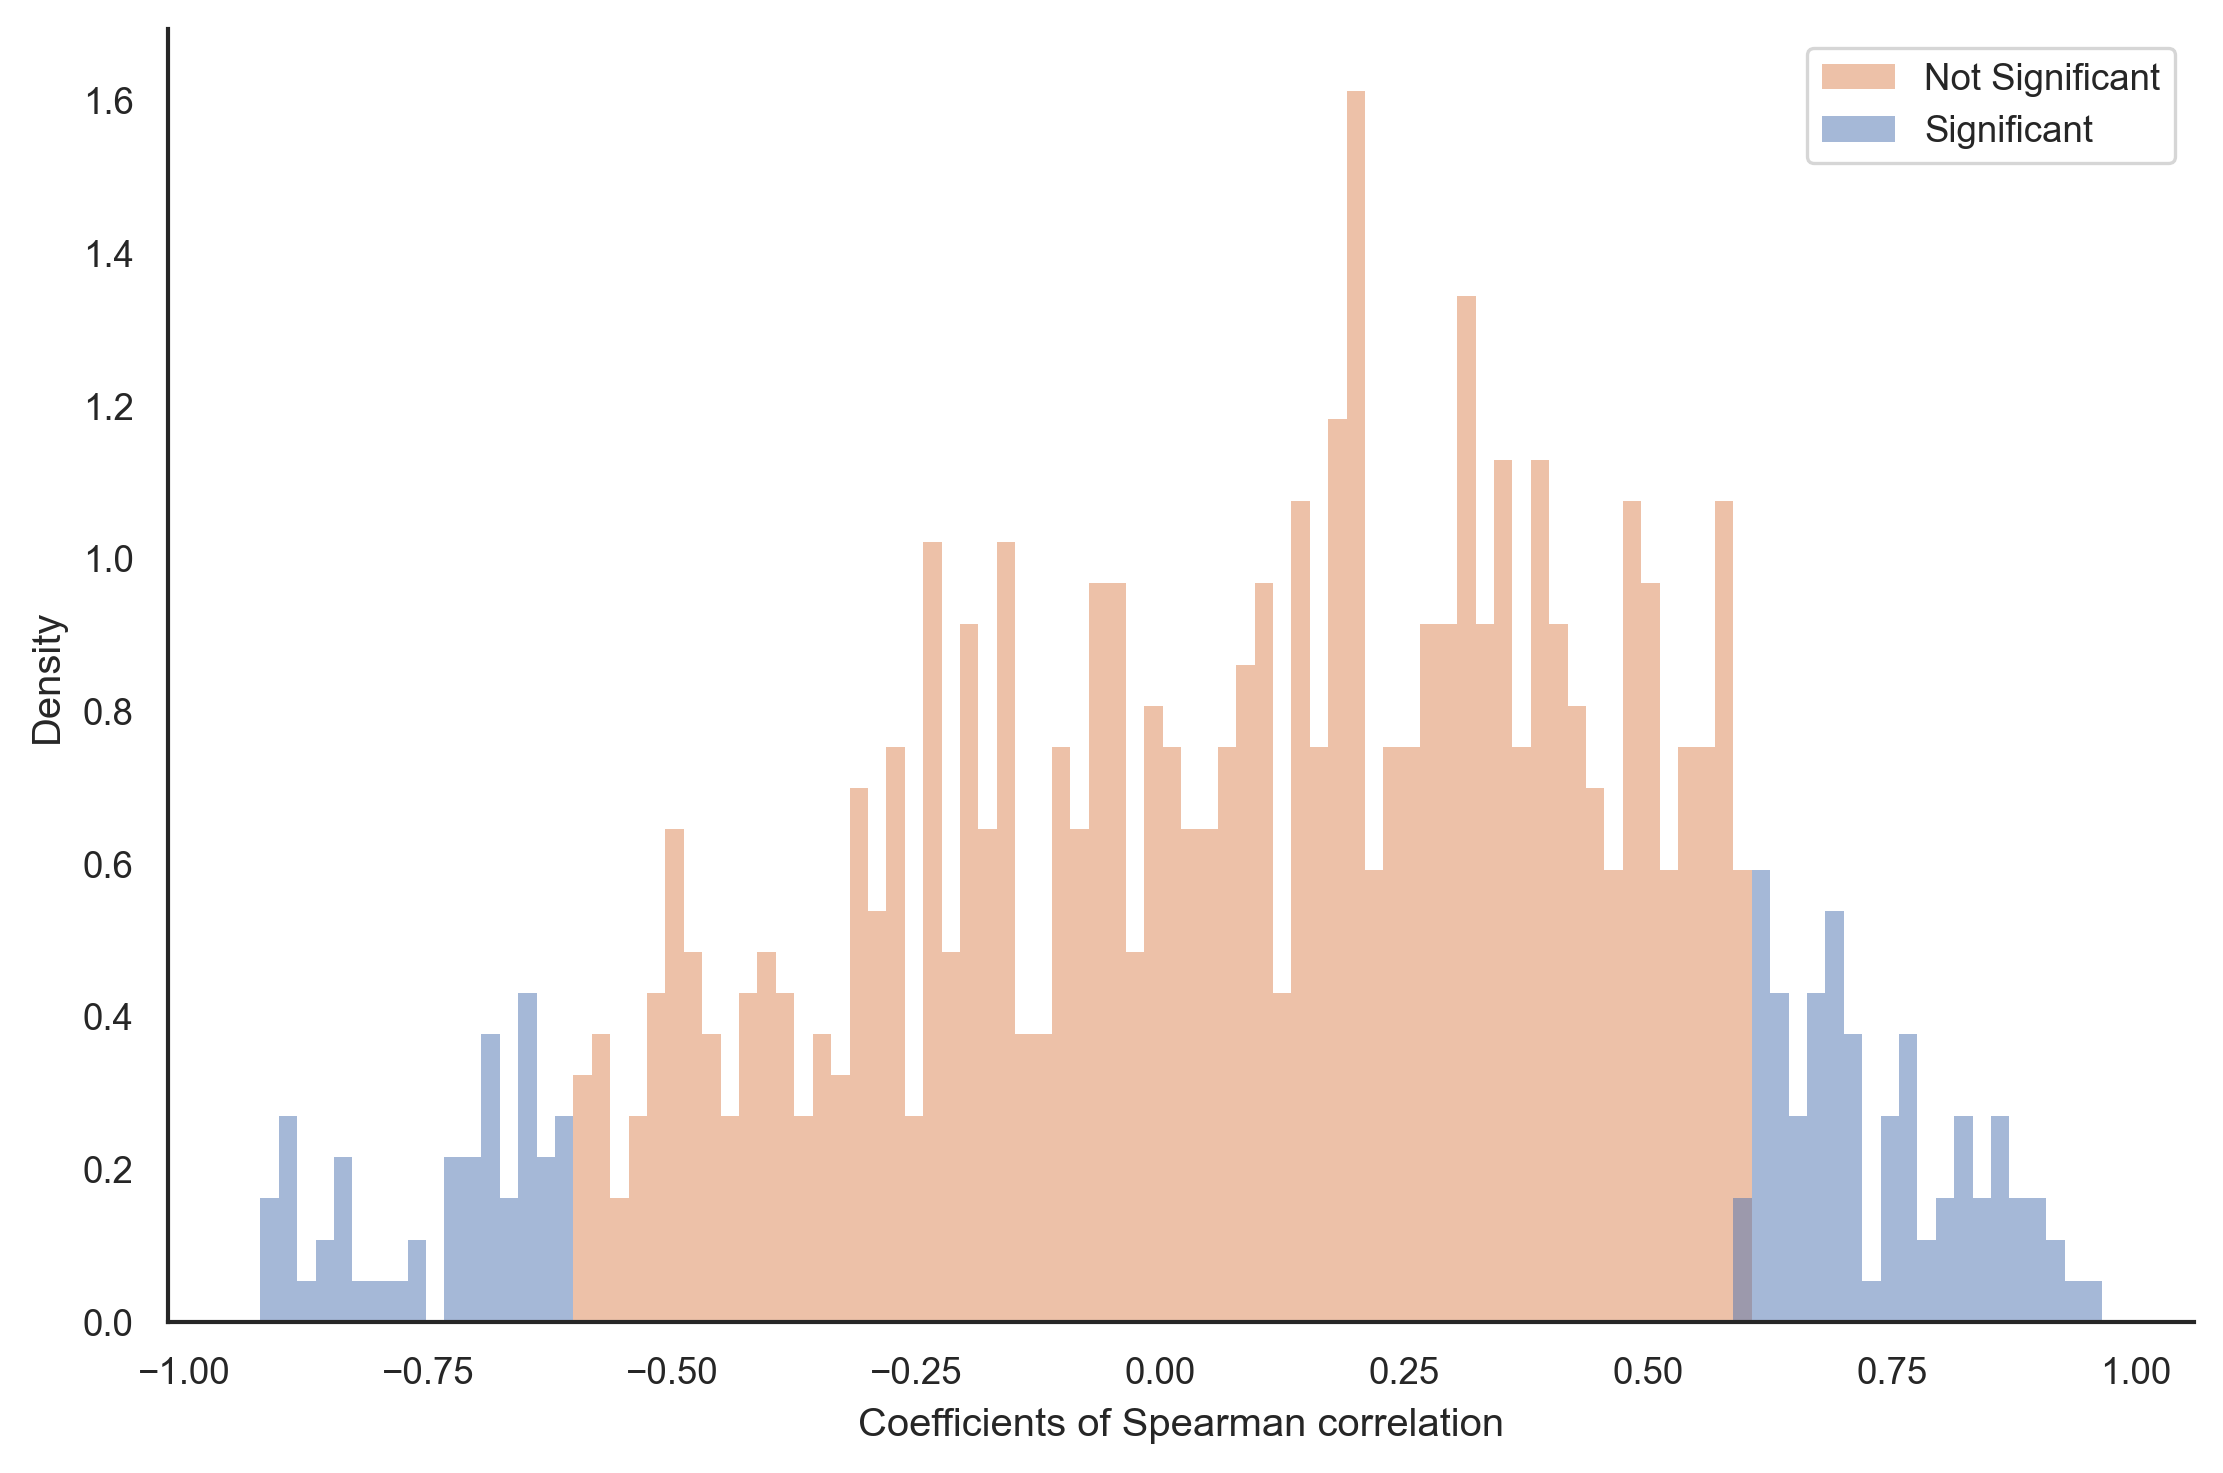

In [13]:
df_spearman_coef = pd.read_csv("./02_df_spearman_coef_w_pval.csv")
# Set the significant level
df_spearman_coef['Significant level'] = pd.cut(df_spearman_coef['p-val'], [0, 0.05, 1], labels=[ "Not Significant", "Significant"])
#df_spearman_coef

ax = sns.displot(df_spearman_coef, x='coef', hue='Significant level',  #shrink=.8 ,
    bins=100, linewidth=0, kde=False, stat="density",  aspect=1.5, legend=False)
ax.set(ylabel='Density', xlabel='Coefficients of Spearman correlation')#, title='Distribution of the Spearman Correlation Coefficients on Simulated Data')

plt.legend(title='', loc='upper right', labels=[ 'Not Significant','Significant'])
plt.show(ax)

---

## Dynamic of sequence lengths

#### Plot emperical gap length distribution: Tips vs. Root

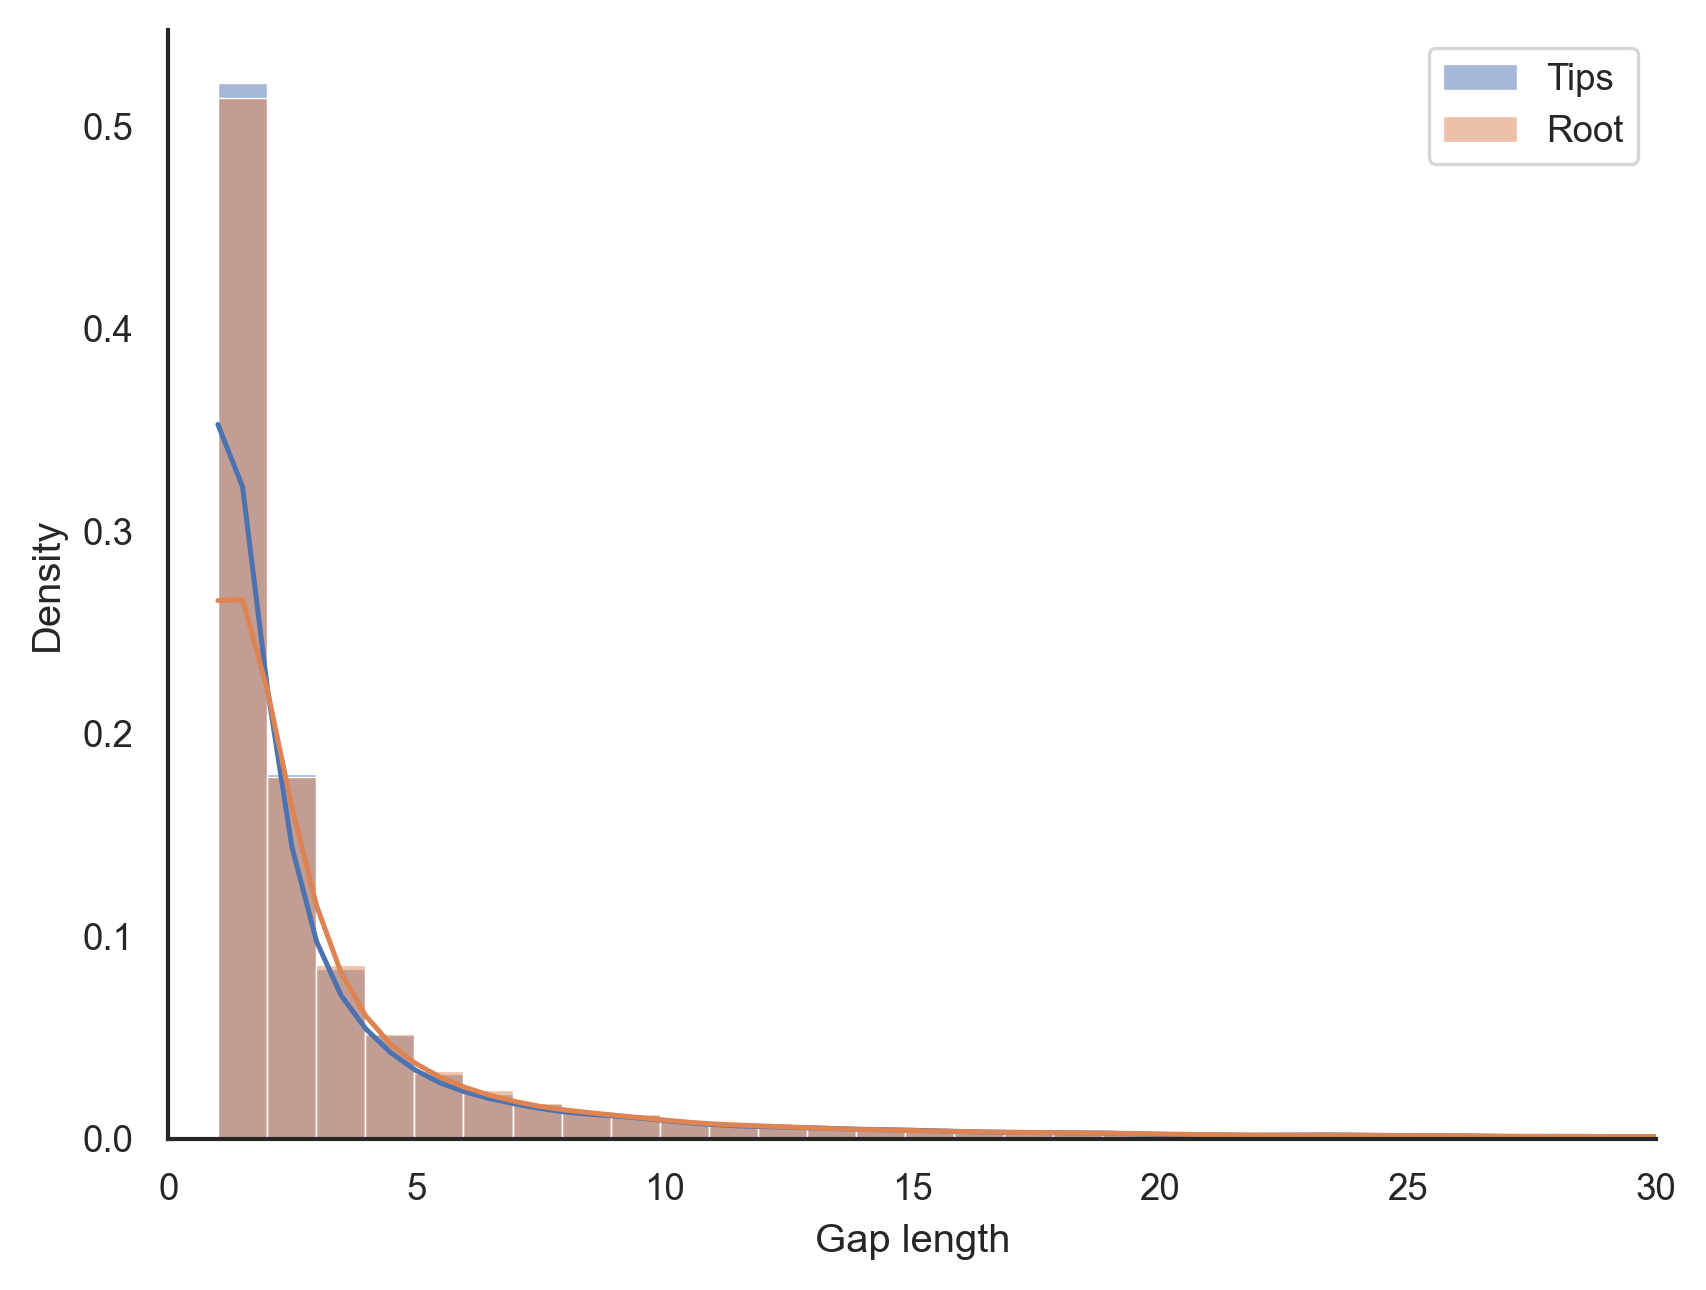

In [24]:
# Reading the dataframe
df_taxa_gap_len = pd.read_json('./02_dynamic_taxa_gap_length.json')
df_root_gap_len = pd.read_json('./02_dynamic_root_gap_length.json')

# df_taxa_gap_len.head()

threshold=100
filtered_df_taxa = df_taxa_gap_len[df_taxa_gap_len['Gap length'] <= threshold]
filtered_df_root = df_root_gap_len[df_root_gap_len['Gap length'] <= threshold]

fig = sns.histplot( data=filtered_df_taxa, x='Gap length', bins=100, kde=True, stat='density',alpha=0.5, color=color_1, label="Tips" )#, hatch='\\\\'
fig = sns.histplot( data=filtered_df_root, x='Gap length', bins=100, kde=True, stat='density',alpha=0.5, color=color_2, label="Root" )# hatch='--',


fig.set(ylabel='Density', xlabel='Gap length')# title='Plot of the Emperical Gap Length Distributions on Simulated Data: Tips vs. Root')
fig.set_xlim(0, 30)
sns.despine()
plt.legend() 
plt.show()

#### Plot the difference between the average gap length of the tips and the root

Read and compute the difference

In [5]:
df_mean_gap_len = pd.read_csv('./02_dynamic_mean_gap_length_taxa_root.csv')
df_dist = df_mean_gap_len['taxa']-df_mean_gap_len['root']
df_dist = pd.DataFrame({'Difference': df_dist})
df_dist.head()

,Difference
0,-0.873509
1,0.080210
2,-0.847222
3,0.006804
4,3.625000


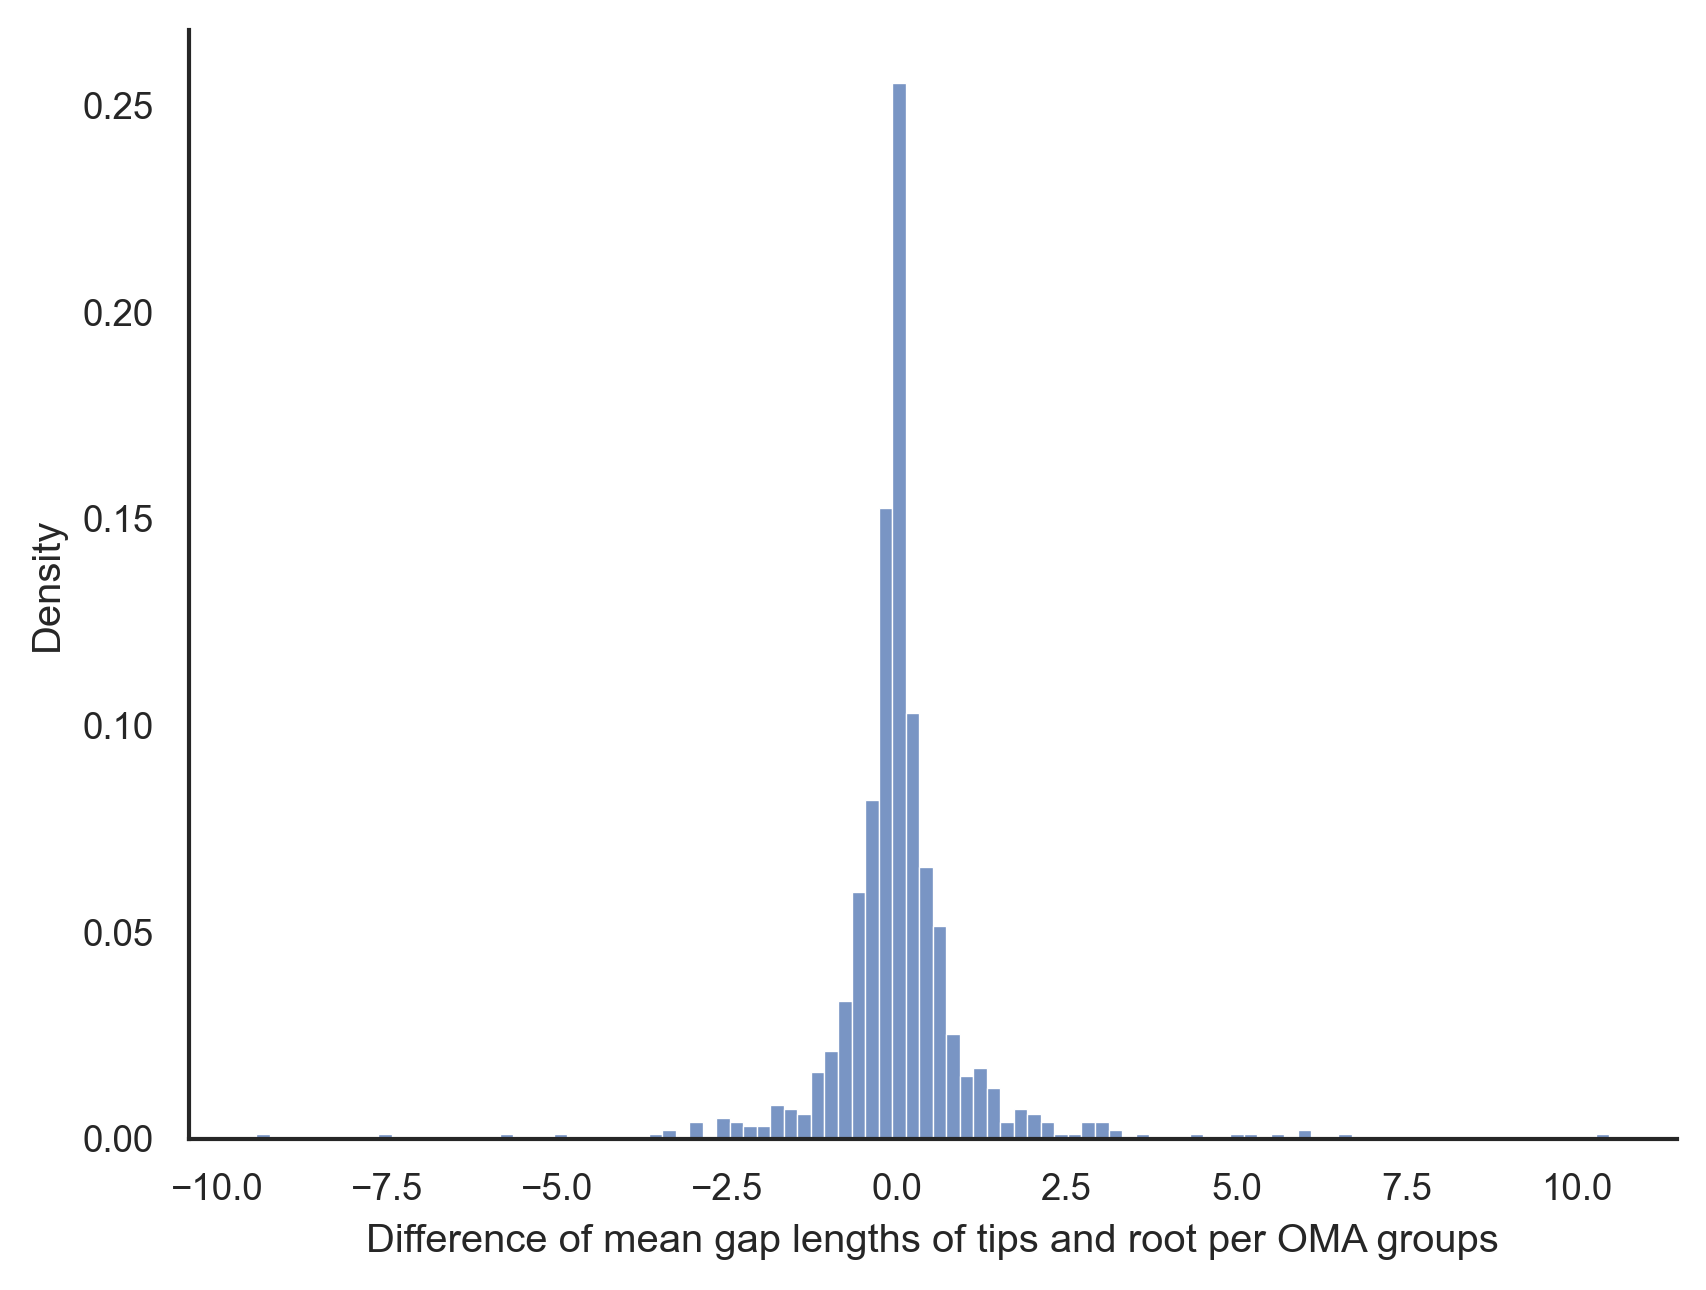

In [6]:
# The empirical distribution of the paired differences between the tips and the root
fig = sns.histplot( data = df_dist, x='Difference', bins=100, kde=0, stat='probability', color=color_1, label="Distance")
fig.set(ylabel='Density', xlabel='Difference of mean gap lengths of tips and root per OMA groups')#, title='The Empirical Distribution of the Paired Differences between Tips and Root on Simulated Data')
sns.despine()
# plt.legend() 
plt.show()

#### The average over all the differences.

In [27]:
df_dist.mean()

Difference    0.019672
dtype: float64

---

## Overlapped Emperical Gap Length Distributions: ARPIP inference vs. INDELible true values

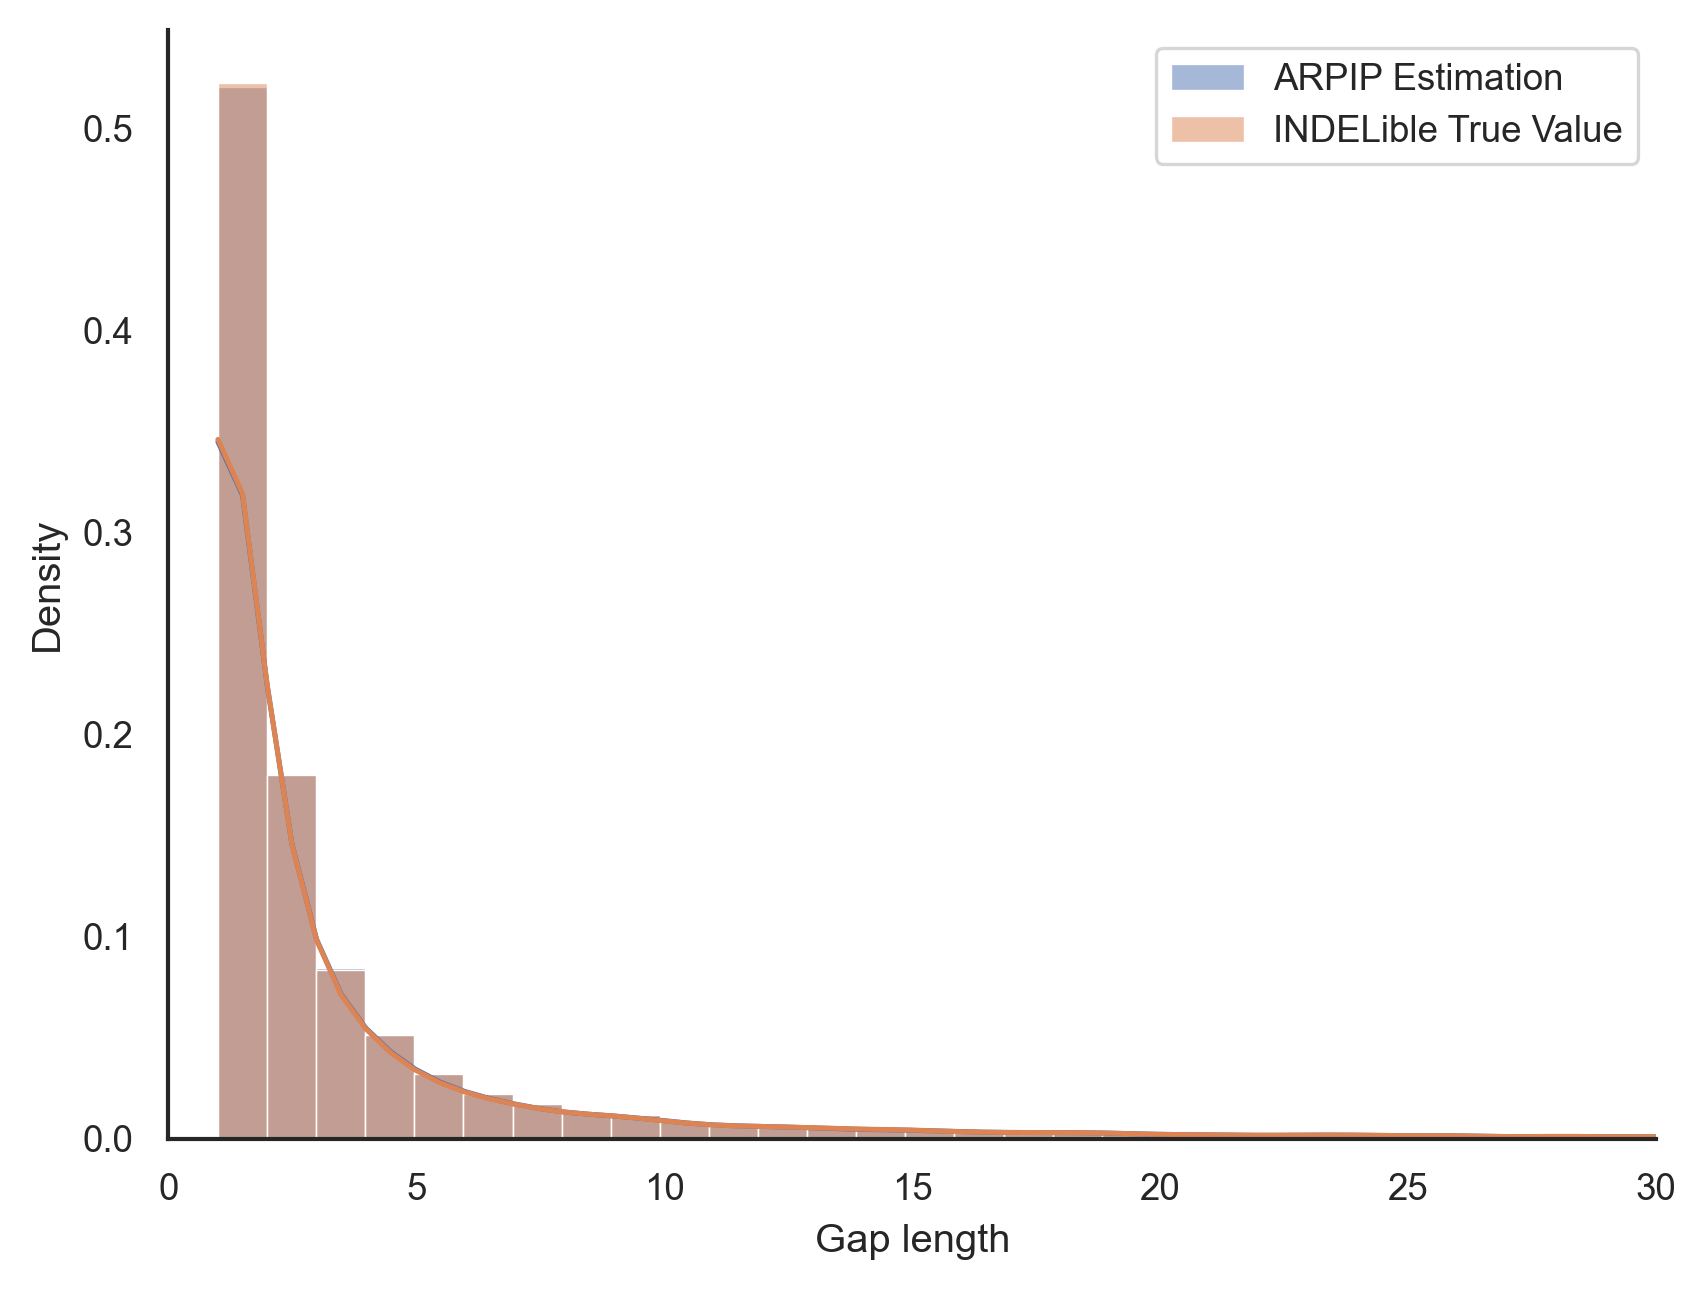

In [2]:
# Reading the dataframes
df_arpip_gap_len = pd.read_json('./02_arpip_asr_gap_length.json')
df_indelible_gap_len = pd.read_json('./02_indelible_as_gap_length.json')


threshold=100
filtered_df_arpip_gap_len = df_arpip_gap_len[df_arpip_gap_len['Gap length'] <= threshold]
filtered_df_indelible_gap_len = df_indelible_gap_len[df_indelible_gap_len['Gap length'] <= threshold]

# Create Seaborn histplot for each distribution
fig = sns.histplot(data=filtered_df_arpip_gap_len, x='Gap length', alpha=0.5, kde=True, stat='density', color=color_1, label='ARPIP Estimation', bins=100)#hatch='\\\\'
fig = sns.histplot(data=filtered_df_indelible_gap_len, x='Gap length', alpha=0.5, kde=True, stat='density', color=color_2, label='INDELible True Value', bins=100)#hatch='--',

sns.despine()
fig.set_xlim(0, 30)
# Add legend, labels, and title
plt.legend()
plt.xlabel('Gap length')
plt.ylabel('Density')
# plt.title('Overlapped Emperical Gap Length Distributions:ARPIP vs. INDELible')
plt.show()

C:\Users\jowkar\AppData\Local\Temp\ipykernel_804\3331385939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_arpip_gap_len['category'] = 'ARPIP Estimation'
C:\Users\jowkar\AppData\Local\Temp\ipykernel_804\3331385939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_indelible_gap_len['category'] = 'INDELible True Value'


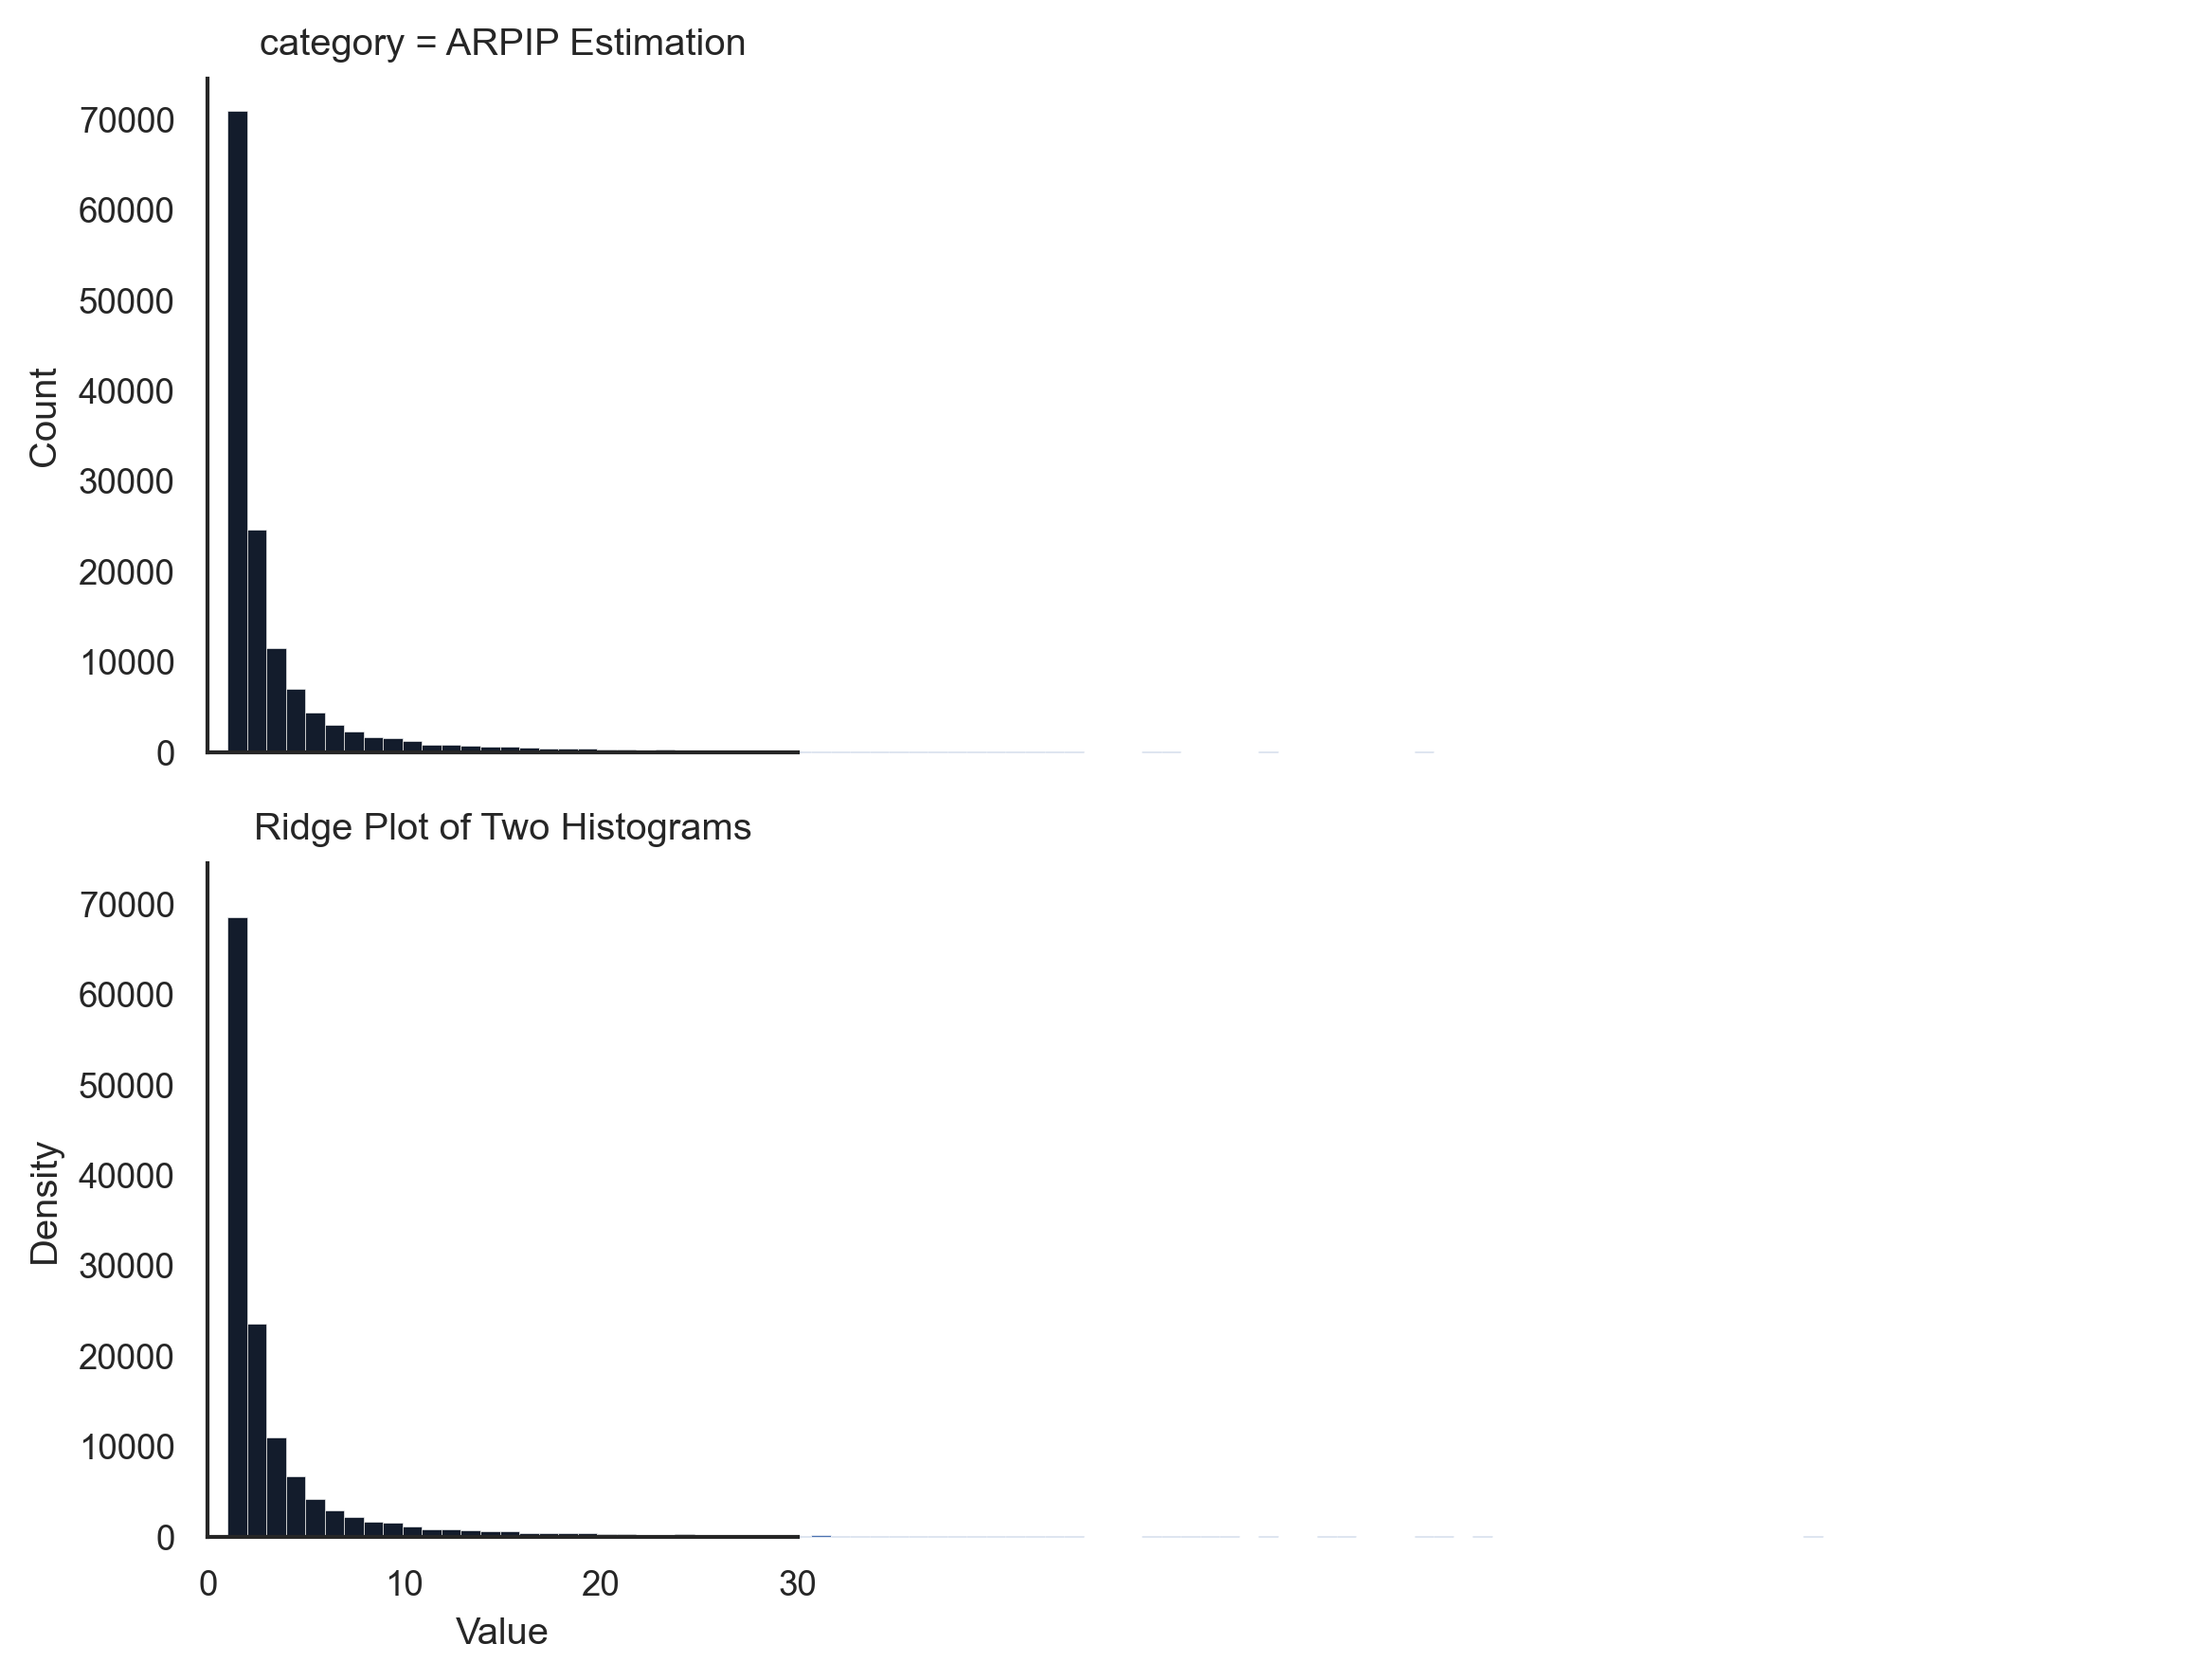

In [18]:
filtered_df_arpip_gap_len['category'] = 'ARPIP Estimation'
filtered_df_indelible_gap_len['category'] = 'INDELible True Value'
combined_df = pd.concat([filtered_df_arpip_gap_len, filtered_df_indelible_gap_len], ignore_index=True)


# Use seaborn's kdeplot to create the ridge plot
# sns.kdeplot(data=combined_df, x='Gap length', hue='category', fill=True, common_norm=False, alpha=.5, linewidth=1.5)
g = sns.FacetGrid(combined_df, row='category')
g.map_dataframe(sns.histplot, x='Gap length', fill=True, alpha=1, clip_on=False,  bins=100)
g.map_dataframe(sns.histplot, x='Gap length', color='black',bins=100 )

# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0, .2, label, color='black', fontsize=13,
#             ha="left", va="center", transform=ax.transAxes)
# g.tight_layout()
# g.map(label, "spc")
# g.fig.subplots_adjust(hspace=-.1)
# g.set_titles("")
# g.set(yticklabels=[])
# g.set(ylabel=None)
# g.set(yticks=[], xlabel="Branch length")
# g.despine(left=True)
plt.xlim([0, 30])
# plt.ylim([0,30])
# plt.suptitle('Branch length distribution', y=0.98)

# Customize the plot
plt.title('Ridge Plot of Two Histograms')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()


#### Comparing two distributions: KL divergence 

In [9]:
import numpy as np

def kl_divergence(p, q):
    """
    Compute the KL divergence between two probability distributions.

    Parameters:
    - p, q: Arrays representing the probability distributions.

    Returns:
    - kl_div: KL divergence value.
    """
    kl_div = np.sum(np.where(q != 0, p * np.log(p / q), 0))
    return kl_div

In [15]:
# Kullback-Leibler Divergence: KL divergence of gap lengths
import numpy as np
from scipy.special import rel_entr, kl_div

df_arpip_gap_len = pd.read_json('./02_arpip_asr_gap_length.json')
print("length of ARPIP gap array", len(df_arpip_gap_len))
df_indelible_gap_len = pd.read_json('./02_indelible_as_gap_length.json')
print("length of INDELible gap array", len(df_indelible_gap_len))

threshold=100
filtered_df_arpip_gap_len = df_arpip_gap_len[df_arpip_gap_len['Gap length'] <= threshold]
print("Filtered: length of ARPIP gap array", len(filtered_df_arpip_gap_len))
filtered_df_indelible_gap_len = df_indelible_gap_len[df_indelible_gap_len['Gap length'] <= threshold]
print("Filtered: length of INDELible gap array", len(filtered_df_indelible_gap_len))

hist1, bin_edges = np.histogram(df_indelible_gap_len['Gap length'], bins=100, density=False)
p = hist1 / hist1.sum()
# print(hist1)
# print(bin_edges)
# print("The p vector is:", p)

hist2, bin_edges = np.histogram(df_arpip_gap_len['Gap length'], bins=100, density=False)
q = hist2/ hist2.sum()
# print("The q vetor is:", q)
 
print('KL-divergence(p || q): %.8f ' % sum(kl_div(p,q)))
print('KL-divergence(q || p): %.8f ' % sum(kl_div(q,p)))
print('KL-divergence(p || p): %.8f ' % sum(kl_div(p,p)))
print('KL-divergence(q || q): %.8f ' % sum(kl_div(q,q)))

# After removing p(i)=0

# Compute KL divergence
kl_value = kl_divergence(p, q)

print(f"KL Divergence: {kl_value}")


length of ARPIP gap array 137876
length of INDELible gap array 132516
Filtered: length of ARPIP gap arry 137764
Filtered: length of INDELible gap arry 132406
KL-divergence(p || q): 0.00004419 
KL-divergence(q || p): 0.00004569 
KL-divergence(p || p): 0.00000000 
KL-divergence(q || q): 0.00000000 
KL Divergence: 4.418990788073249e-05


C:\Users\jowk\AppData\Local\Temp/ipykernel_11420/3256369532.py:13: RuntimeWarning: invalid value encountered in true_divide
  kl_div = np.sum(np.where(q != 0, p * np.log(p / q), 0))


---
# Revised version

In [33]:
# Read the two data frames
df_sim_bl = pd.read_csv('./01_br_len_per_OMA_per_species.csv', index_col=0)

df_sim_bl = df_sim_bl.rename(columns={'Mus': 'tree_Mus', 'Rattus': 'tree_Rattus', 'V2':'tree_V2',
                                  'Pan':'tree_Pan', 'Homo':'tree_Homo', 'V5':'tree_V5', 'Gorilla':'tree_Gorilla',
                                  'V7':'tree_V7', 'Macaca':'tree_Macaca', 'V9':'tree_V9', 'root':'tree_root'})

df_sim_bl = df_sim_bl.iloc[:,[0,1,3,4,6,8,2,5,7,9,10]]

# df_bl.reset_index(inplace=True)
df_sim_bl = df_sim_bl.rename(columns = {'index':'OMA_group'})
# display(df_bl)
# df_bl.to_csv('../branch_len_per_OMA_per_species.csv')

df_sim_bl.head()

,tree_Mus,tree_Rattus,tree_Pan,tree_Homo,tree_Gorilla,tree_Macaca,tree_V2,tree_V5,tree_V7,tree_V9,tree_root
OMA_group,,,,,,,,,,,
1000131,0.06766,0.08055,0.01097,0.01101,0.00010,0.07313,0.17706,0.00010,0.05973,0.18448,0
1000249,0.04694,0.05666,0.00250,0.00766,0.02534,0.04953,0.15057,0.00558,0.02631,0.15558,0
1000358,0.02700,0.03442,0.00188,0.00195,0.00513,0.01323,0.09921,0.00010,0.01015,0.11834,0
1000360,0.06092,0.02474,0.00010,0.00777,0.06655,0.03881,0.11426,0.00010,0.02275,0.08588,0
1000362,0.00701,0.00399,0.00010,0.00010,0.00010,0.00196,0.01871,0.00010,0.00349,0.02223,0


In [34]:
df_sim_seq = pd.read_csv('./01_dynamic_seq_len_per_OMA_per_species.csv', index_col=0)

#sequence length
df_sim_seq = df_sim_seq.rename(columns={'Mouse': 'seq_Mus', 'Rat': 'seq_Rattus', 'V2':'seq_V2',
                                  'Chimp':'seq_Pan', 'Human':'seq_Homo', 'V5':'seq_V5', 'Gorilla':'seq_Gorilla',
                                  'V7':'seq_V7', 'Macaque':'seq_Macaca', 'V9':'seq_V9', 'root':'seq_root'})
# df_seq.head()
# df_seq = df_seq.iloc[:,[0,10,11,9,7,8,6,1,2,3,4,5]]
df_sim_seq = df_sim_seq.rename(columns={'index':'OMA_group'})
# print("Sequence length dataframe")
# # df_seq.to_csv('../seq_len_per_OMA_per_species.csv')

df_sim_seq.head()

,seq_Mus,seq_Rattus,seq_Pan,seq_Homo,seq_Gorilla,seq_Macaca,seq_V2,seq_V5,seq_V7,seq_V9,seq_root
OMA_group,,,,,,,,,,,
1000131,941,925,988,987,987,937,938,987,987,955,785
1000249,1008,964,991,991,991,990,984,991,991,989,928
1000358,1097,992,1006,1006,1006,1009,999,1006,1006,1009,999
1000360,1000,982,998,1000,997,1000,986,998,998,992,992
1000362,1012,1025,988,988,988,990,1025,988,988,990,1025


In [12]:
#merge two tables
df_dynamic = pd.merge(df_sim_seq, df_sim_bl, on='OMA_group', how='inner')
df_dynamic.to_csv('./01_dynamic_joint_br_seq_len_per_OMA_per_species.csv')
print("The dynamic datafram has been written successfully.")

The dynamic datafram has been written successfully.


In [35]:
df_dynamic = pd.read_csv('./01_dynamic_joint_br_seq_len_per_OMA_per_species.csv', index_col=0)
display(df_dynamic)

,seq_Mus,seq_Rattus,seq_Pan,seq_Homo,seq_Gorilla,seq_Macaca,seq_V2,seq_V5,seq_V7,seq_V9,...,tree_Rattus,tree_Pan,tree_Homo,tree_Gorilla,tree_Macaca,tree_V2,tree_V5,tree_V7,tree_V9,tree_root
OMA_group,,,,,,,,,,,,,,,,,,,,,
1000131,941,925,988,987,987,937,938,987,987,955,...,0.08055,0.01097,0.01101,0.00010,0.07313,0.17706,0.00010,0.05973,0.18448,0
1000249,1008,964,991,991,991,990,984,991,991,989,...,0.05666,0.00250,0.00766,0.02534,0.04953,0.15057,0.00558,0.02631,0.15558,0
1000358,1097,992,1006,1006,1006,1009,999,1006,1006,1009,...,0.03442,0.00188,0.00195,0.00513,0.01323,0.09921,0.00010,0.01015,0.11834,0
1000360,1000,982,998,1000,997,1000,986,998,998,992,...,0.02474,0.00010,0.00777,0.06655,0.03881,0.11426,0.00010,0.02275,0.08588,0
1000362,1012,1025,988,988,988,990,1025,988,988,990,...,0.00399,0.00010,0.00010,0.00010,0.00196,0.01871,0.00010,0.00349,0.02223,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999139,1004,1013,1011,1011,1011,1011,1003,1011,1011,1011,...,0.00725,0.00010,0.00010,0.00010,0.00521,0.02070,0.00010,0.00088,0.02714,0
999464,1038,1048,1167,1130,1121,1016,1037,1119,1119,1034,...,0.01816,0.04140,0.00122,0.00361,0.03465,0.06293,0.00125,0.01392,0.02452,0
999465,1004,985,946,1023,1025,1005,1006,1022,1027,1006,...,0.04172,0.03283,0.00200,0.00874,0.03406,0.10494,0.00218,0.02380,0.08785,0


In [17]:
df_dynamic.iloc[1, 0:11]


seq_Mus        1008.0
seq_Rattus      964.0
seq_Pan         991.0
seq_Homo        991.0
seq_Gorilla     991.0
seq_Macaca      990.0
seq_V2          984.0
seq_V5          991.0
seq_V7          991.0
seq_V9          989.0
seq_root        928.0
Name: 1000249, dtype: float64

In [19]:
df_dynamic.iloc[1,11:]

tree_Mus        0.04694
tree_Rattus     0.05666
tree_Pan        0.00250
tree_Homo       0.00766
tree_Gorilla    0.02534
tree_Macaca     0.04953
tree_V2         0.15057
tree_V5         0.00558
tree_V7         0.02631
tree_V9         0.15558
tree_root       0.00000
Name: 1000249, dtype: float64

In [37]:
# Correlation Coefficients
dict_spearman_coef = {}

for i in range(len(df_dynamic)):
    y = df_dynamic.iloc[i, 0:11] #y values are the sequence lengths
    x = df_dynamic.iloc[i, 11:] #x values are the corresponding branch length
    
    dict_spearman_coef[df_dynamic.iloc[i,1]] = spearmanr(x, y)
    

df_spearman_coef = pd.DataFrame.from_dict(dict_spearman_coef, orient='index')
df_spearman_coef.columns = ['coef', 'p-val']
df_spearman_coef.to_csv("./02_br_df_spearman_coef_w_pval.csv")


print("Done")

C:\Users\jowkar\.conda\envs\env01\lib\site-packages\scipy\stats\_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Done


In [23]:
#percentage of significant
print("Total number of non-nan samples:",len(df_spearman_coef))
print("********************************************************")

df_significant_spearman = df_spearman_coef[df_spearman_coef['p-val']<= 0.05]
spearman_significant_data_prc = (len(df_significant_spearman)/ len(df_spearman_coef))
print("Percentage of samples with significant Spearman correlation coefficient: {:.2%}".format(spearman_significant_data_prc))

print("Count of samples with significant Spearman correlation coefficient:",len(df_significant_spearman))

df_significant_spearman_positive = df_spearman_coef[(df_spearman_coef['p-val']<= 0.05) & (df_spearman_coef['coef']>=0)]
print("Count of samples with significant Spearman correlation coefficient and posivite coefficient:",len(df_significant_spearman_positive))

df_significant_spearman_negative = df_spearman_coef[(df_spearman_coef['p-val']<= 0.05) & (df_spearman_coef['coef']<0)]
print("Count of samples with significant Spearman correlation coefficient and negative coefficient:",len(df_significant_spearman_negative))
print("********************************************************")


Total number of non-nan samples: 177
********************************************************
Percentage of samples with significant Spearman correlation coefficient: 7.91%
Count of samples with significant Spearman correlation coefficient: 14
Count of samples with significant Spearman correlation coefficient and posivite coefficient: 11
Count of samples with significant Spearman correlation coefficient and negative coefficient: 3
********************************************************


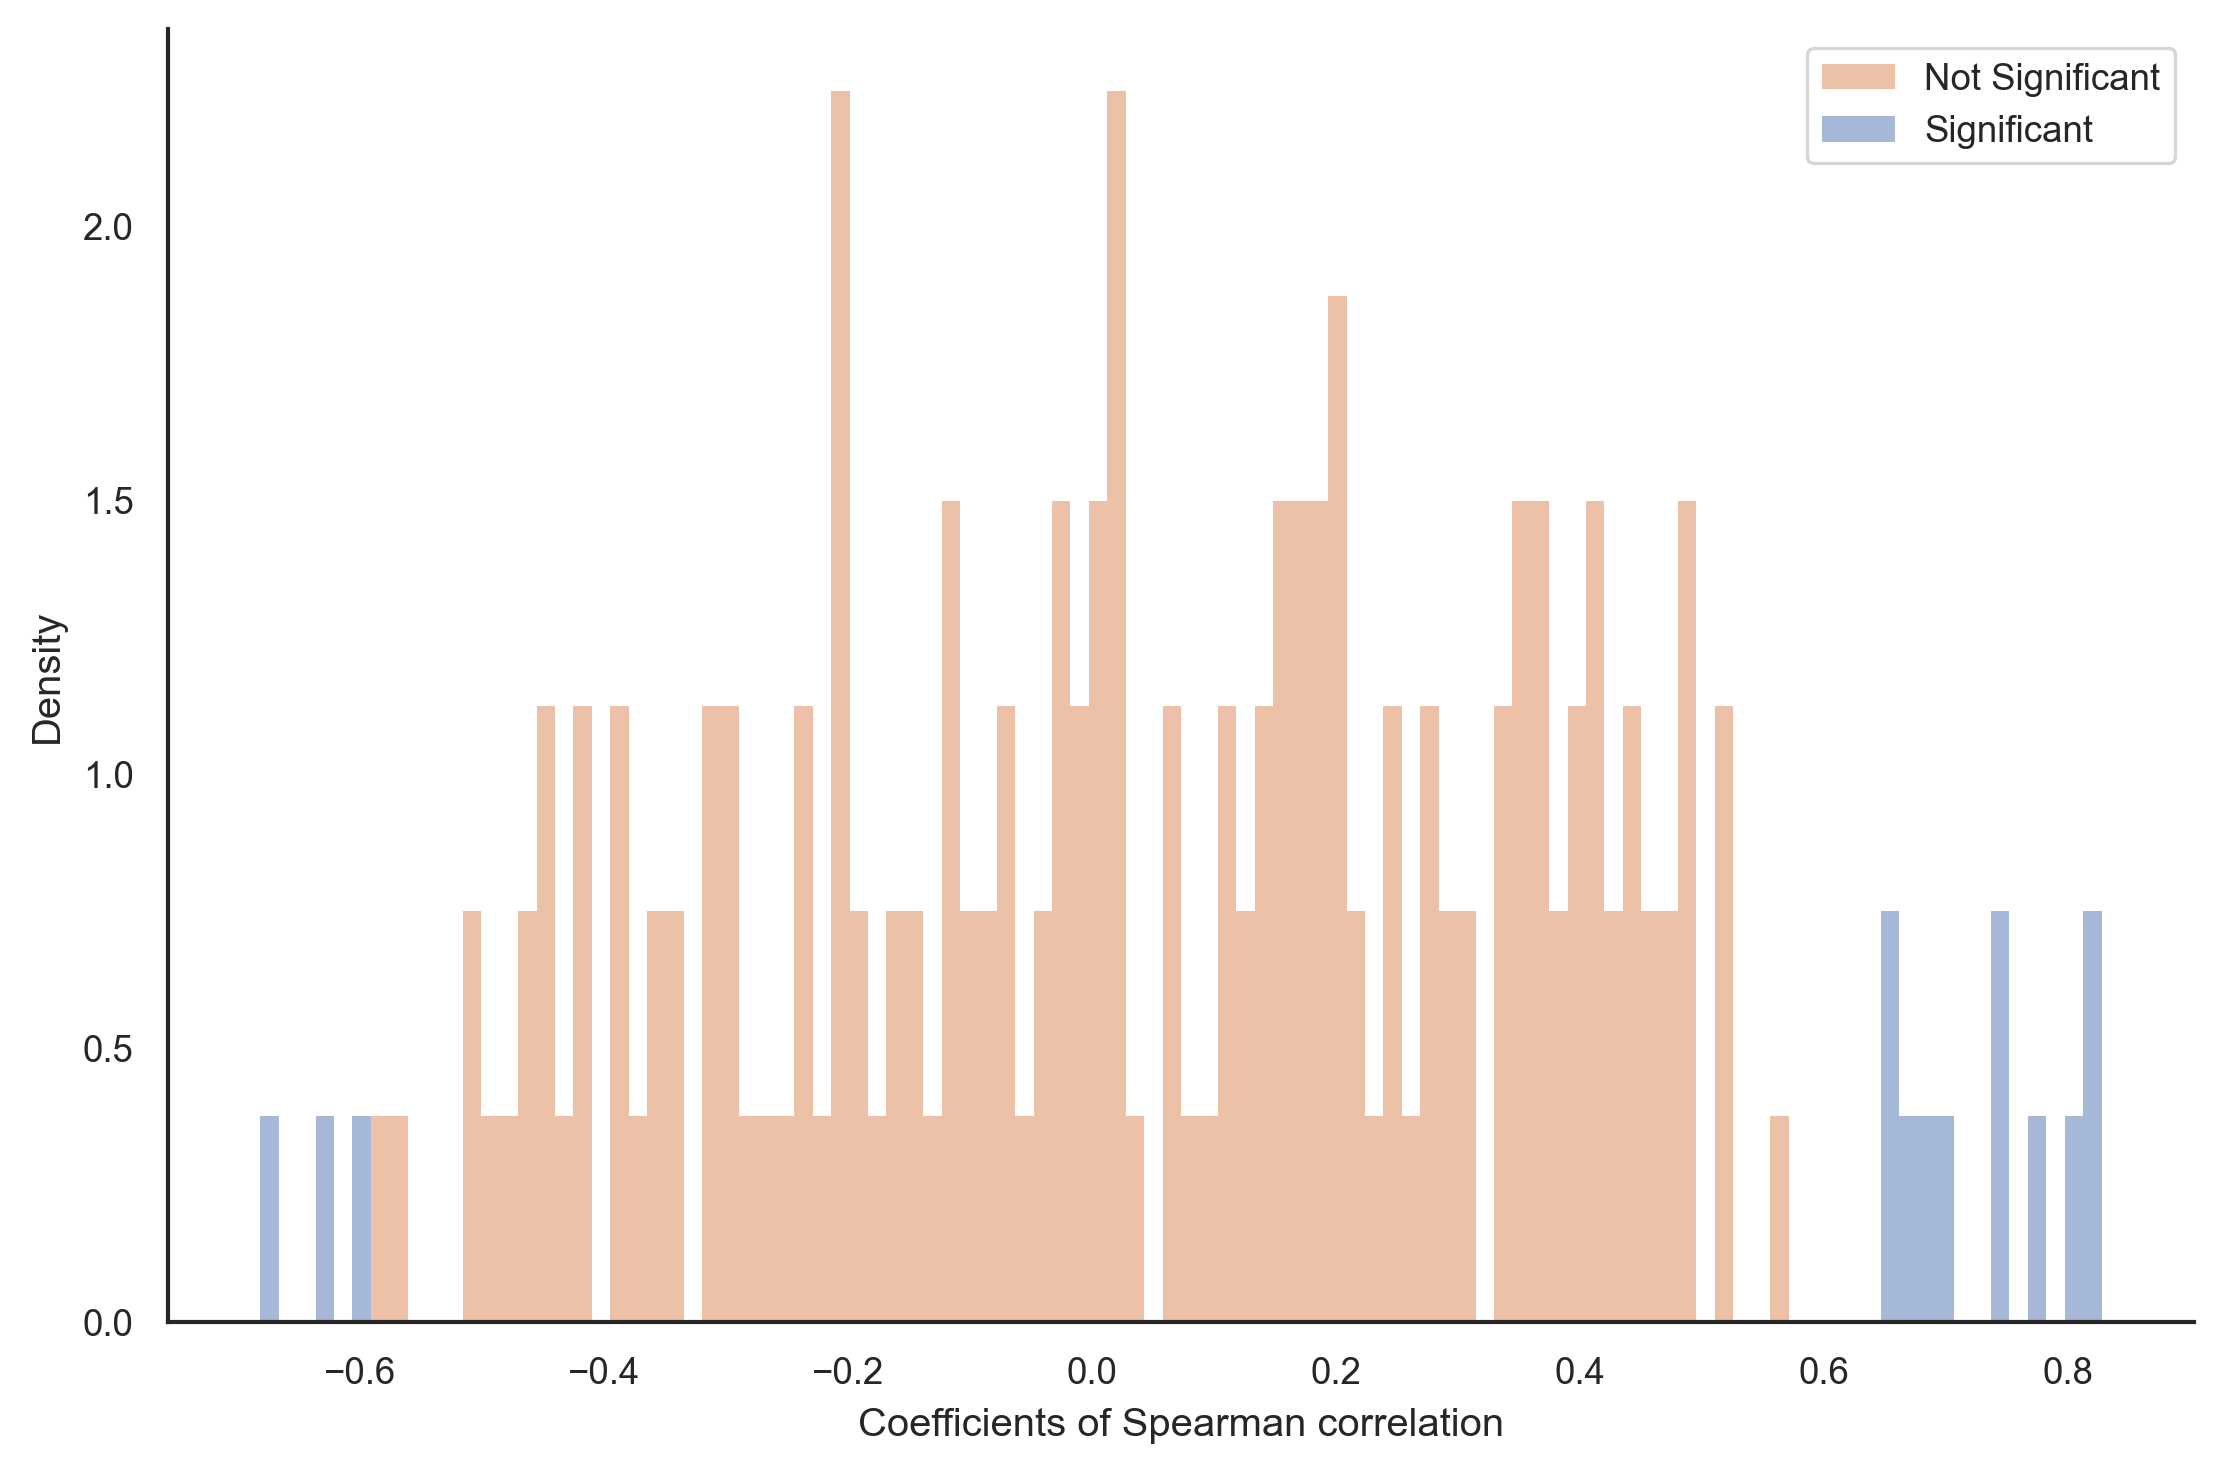

In [25]:
df_spearman_coef = pd.read_csv("./02_br_df_spearman_coef_w_pval.csv")
# Set the significant level
df_spearman_coef['Significant level'] = pd.cut(df_spearman_coef['p-val'], [0, 0.05, 1], labels=[ "Not Significant", "Significant"])
#df_spearman_coef

ax = sns.displot(df_spearman_coef, x='coef', hue='Significant level',  #shrink=.8 ,
    bins=100, linewidth=0, kde=False, stat="density",  aspect=1.5, legend=False)
ax.set(ylabel='Density', xlabel='Coefficients of Spearman correlation')#, title='Distribution of the Spearman Correlation Coefficients on Simulated Data')

plt.legend(title='', loc='upper right', labels=[ 'Not Significant','Significant'])
plt.show(ax)

## Kolmogorov-Smirnov test instead of KL divergence

In [40]:
from scipy.stats import ks_2samp

df_taxa_gap_len = pd.read_json('./02_dynamic_taxa_gap_length.json')
df_root_gap_len = pd.read_json('./02_dynamic_root_gap_length.json')

# df_taxa_gap_len.head()

threshold=100
filtered_df_taxa = df_taxa_gap_len[df_taxa_gap_len['Gap length'] <= threshold]
filtered_df_root = df_root_gap_len[df_root_gap_len['Gap length'] <= threshold]


# Run Kolmogorov-Smirnov test
print(ks_2samp(list(filtered_df_root['Gap length']), list(filtered_df_taxa['Gap length'])))

KstestResult(statistic=0.009042220464264172, pvalue=0.028486586934631353)


In [41]:
# Reading the dataframes
df_arpip_gap_len = pd.read_json('./02_arpip_asr_gap_length.json')
df_indelible_gap_len = pd.read_json('./02_indelible_as_gap_length.json')


threshold=100
filtered_df_arpip_gap_len = df_arpip_gap_len[df_arpip_gap_len['Gap length'] <= threshold]
filtered_df_indelible_gap_len = df_indelible_gap_len[df_indelible_gap_len['Gap length'] <= threshold]

# Run Kolmogorov-Smirnov test
print(ks_2samp(list(filtered_df_arpip_gap_len['Gap length']), list(filtered_df_indelible_gap_len['Gap length'])))

KstestResult(statistic=0.002063115372280544, pvalue=0.9355265418241366)
